In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import math
import os
from skimage.measure import regionprops
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

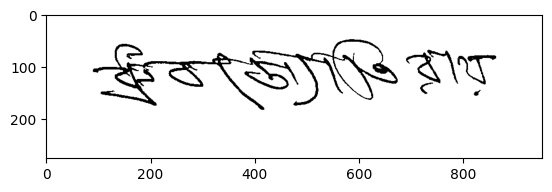

In [2]:
img = cv2.imread('C:\\Users\\Gitesh Singh Phogat\\Desktop\\signature verification\\BHSig260\\Bengali\\001\\B-S-1-F-01.tif',0)
plt.imshow(img, 'gray')
plt.show()

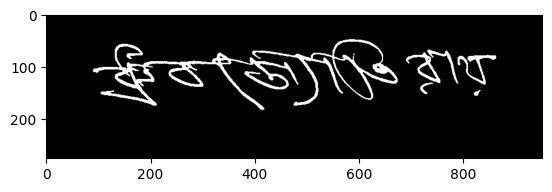

In [3]:
def otsu(img):
    kernal_size=(3,3)
    b = cv2.blur(img,kernal_size) # mean filter
    ret3,th3 = cv2.threshold(b,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return th3

oimg=otsu(img)  
plt.imshow(oimg,'gray')
plt.show()

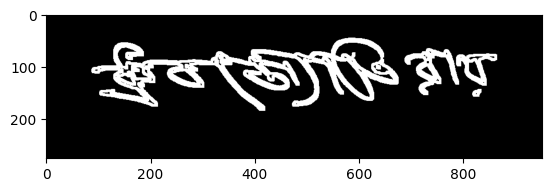

In [4]:
def thickening(img):
    # Apply Canny edge detection to the blurred image
    edges = cv2.Canny(img, 100, 200)

    # Dilate the edges to make them thicker
    kernel = np.ones((5,5), np.uint8)
    return cv2.dilate(edges, kernel, iterations=1)

    cv2.imshow('Dilated Edges', dilated_edges)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

timg=thickening(oimg)
plt.imshow(timg,'gray')
plt.show()

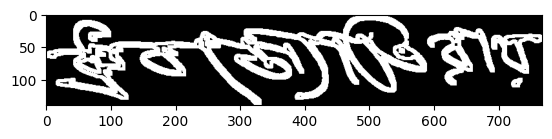

In [5]:
def crop_image(img,tol=0):
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

cimg=crop_image(timg,0)
plt.imshow(cimg,'gray')
plt.show()

In [ ]:
def preprocessing(train_path):
    x_train=[]
    y_train=[]
    for sub_path in os.listdir(train_path):
        image_path = train_path + '\\' +sub_path 
        count=0
        for img in os.listdir(image_path):
            count+=1
            
            temp = cv2.imread(image_path + '/' + img, 0) #greyscale
            temp= otsu(temp) #binarization and inversion
            temp=thickening(temp) #thickning
            temp=crop_image(temp) #bounding box
            
            if(count<=30):
                x_train.append(temp)
            else:
                y_train.append(temp)
        
    return x_train,y_train

In [ ]:
train_path='C:\\Users\\Gitesh Singh Phogat\\Desktop\\Signature verification\\BHSig260\\Bengali'
F,R=preprocessing(train_path)

Feature extraction

In [ ]:
def Ratio(img):
    a = 0
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                a = a+1
    total = img.shape[0] * img.shape[1]
    return a/total


def Centroid(img):
    numOfWhites = 0
    a = np.array([0,0])
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                b = np.array([row,col])
                a = np.add(a,b)
                numOfWhites += 1
    rowcols = np.array([img.shape[0], img.shape[1]])
    centroid = a/numOfWhites
    centroid = centroid/rowcols
    return centroid[0], centroid[1]

def EccentricitySolidity(img):
    r = regionprops(img.astype("int"))
    return r[0].eccentricity, r[0].solidity

def SkewKurtosis(img):
    h,w = img.shape
    x = range(w)  # cols value
    y = range(h)  # rows value
    #calculate projections along the x and y axes
    xp = np.sum(img,axis=0)
    yp = np.sum(img,axis=1)
    #centroid
    cx = np.sum(x*xp)/np.sum(xp)
    cy = np.sum(y*yp)/np.sum(yp)
    #standard deviation
    x2 = (x-cx)**2
    y2 = (y-cy)**2
    sx = np.sqrt(np.sum(x2*xp)/np.sum(img))
    sy = np.sqrt(np.sum(y2*yp)/np.sum(img))
    
    #skewness
    x3 = (x-cx)**3
    y3 = (y-cy)**3
    skewx = np.sum(xp*x3)/(np.sum(img) * sx**3)
    skewy = np.sum(yp*y3)/(np.sum(img) * sy**3)

    #Kurtosis
    x4 = (x-cx)**4
    y4 = (y-cy)**4
    # 3 is subtracted to calculate relative to the normal distribution
    kurtx = np.sum(xp*x4)/(np.sum(img) * sx**4) - 3
    kurty = np.sum(yp*y4)/(np.sum(img) * sy**4) - 3

    return (skewx , skewy), (kurtx, kurty)

#mean
def meanStd(img):
    mean = np.mean(img)
    std = np.std(img)
    return mean, std

In [1]:
def getFeatures(img):
    ratio = Ratio(img)
    centroid = Centroid(img)
    eccentricity, solidity = EccentricitySolidity(img)
    skewness, kurtosis = SkewKurtosis(img)
    mean, std= meanStd(img)
    retVal = (ratio, centroid, eccentricity, solidity, skewness, kurtosis, mean, std)
    return retVal

In [ ]:
def getCSVFeatures(img):
    temp = getFeatures(img)
    features = (temp[0], temp[1][0], temp[1][1], temp[2], temp[3], temp[4][0], temp[4][1], temp[5][0], temp[5][1], temp[6], temp[7])
    return features

In [ ]:
def makeCSV():
    if not(os.path.exists('C:\\Users\\Gitesh Singh Phogat\\Desktop\\signature verification\\Features_bengali')):
        os.mkdir('C:\\Users\\Gitesh Singh Phogat\\Desktop\\signature verification/Features_bengali')
        print('New folder "Features_bengali" created')
        
    cF=0
    cR=0
    for person in range(1,101):
        per = ('00'+str(person))[-3:]
        print('Saving features for person id-',per)
        
        with open('C:\\Users\\Gitesh Singh Phogat\\Desktop\\signature verification\\Features_bengali/features_'+per+'.csv', 'w') as handle:
            handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,mean,std,output\n')
            # Training set
            
            #real image
            i=cR
            z=1
            while(i<len(R)):
                features = getCSVFeatures(R[i])
#                 print(i)
#                 plt.imshow(R[i])
#                 plt.show()
                handle.write(','.join(map(str, features))+',1\n')
                i+=1
                if(z==24):
                    break
                z+=1
            cR=i
            
            #forged image
            i=cF
            z=1
            while(i<len(F)):
                features = getCSVFeatures(F[i])
                handle.write(','.join(map(str, features))+',0\n')
                i+=1
                if(z==30):
                    break
                z+=1
            cF=i

In [ ]:
makeCSV()

In [10]:
# Define the folder containing the CSV files
folder_path = 'C:\\Users\\Gitesh Singh Phogat\\Desktop\\signature verification\\Features_bengali'

# Create empty lists to store the data and labels
data = []
labels = []

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    df = pd.read_csv(os.path.join(folder_path, filename))
    
    # Replace NaN values with 0
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    
    data.append(df.iloc[:, :-1].values)
    labels.append(df.iloc[:, -1].values)
    
# Flatten the data and labels lists
data = [item for sublist in data for item in sublist]
labels = [item for sublist in labels for item in sublist]

X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=42)



Training accuracy: 95.43981481481481
Testing accuracy: 77.96296296296296
              precision    recall  f1-score   support

           0       0.79      0.83      0.80       595
           1       0.77      0.72      0.75       485

    accuracy                           0.78      1080
   macro avg       0.78      0.77      0.78      1080
weighted avg       0.78      0.78      0.78      1080

[[491 104]
 [134 351]]


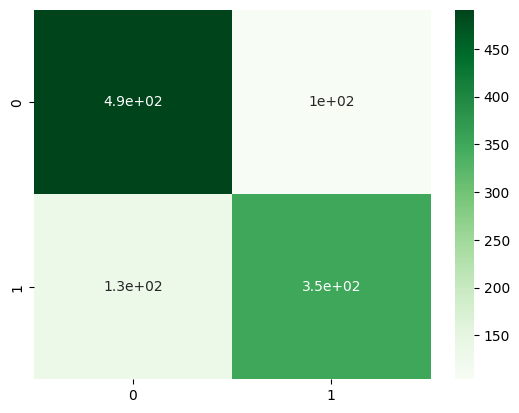

In [58]:
#Decision tree classifier
classifier= DecisionTreeClassifier(max_depth=20)
classifier.fit(X_train,Y_train)

X_train_prediction=classifier.predict(X_train)
dt_training_accuracy= accuracy_score(X_train_prediction,Y_train)

X_test_prediction=classifier.predict(X_test)
dt_test_accuracy= accuracy_score(X_test_prediction,Y_test)

print("Training accuracy:", dt_training_accuracy*100)
print("Testing accuracy:", dt_test_accuracy*100)

# fig, ax = plt.subplots(figsize=(10, 10))
# plot_tree(classifier, ax=ax)
# plt.show()

print(classification_report(Y_test,X_test_prediction))

cm = confusion_matrix(Y_test, X_test_prediction)
print(cm)

sns.heatmap(cm, annot=True, cmap='Greens')
# plt.xlabel('False')
# plt.ylabel('True')
plt.show()

Training Accuracy: 100.0
Testing Accuracy: 86.01851851851852
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       595
           1       0.92      0.76      0.83       485

    accuracy                           0.86      1080
   macro avg       0.87      0.85      0.86      1080
weighted avg       0.87      0.86      0.86      1080

[[561  34]
 [117 368]]


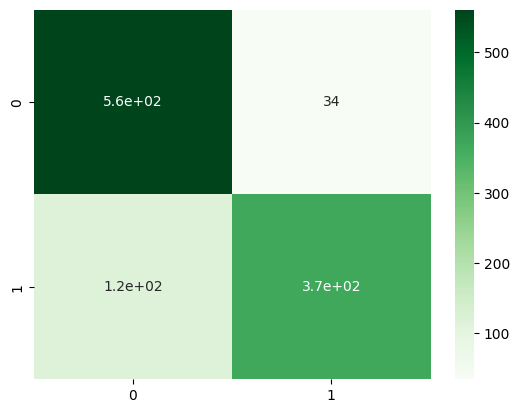

In [11]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=12), n_estimators=1000, random_state=42, )
clf.fit(X_train, Y_train)
clf_preds = clf.predict(X_test)
accuracy = accuracy_score(clf_preds,Y_test)
train_accuracy=clf.score(X_train,Y_train)

print("Training Accuracy:", train_accuracy*100)
print("Testing Accuracy:", accuracy*100)

print(classification_report(Y_test,clf_preds))

cm = confusion_matrix(Y_test, clf_preds)
print(cm)

sns.heatmap(cm, annot=True, cmap='Greens')
plt.show()

Training accuracy: 100.0
Testing accuracy: 83.24074074074073
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       595
           1       0.87      0.73      0.80       485

    accuracy                           0.83      1080
   macro avg       0.84      0.82      0.83      1080
weighted avg       0.84      0.83      0.83      1080

[[544  51]
 [130 355]]


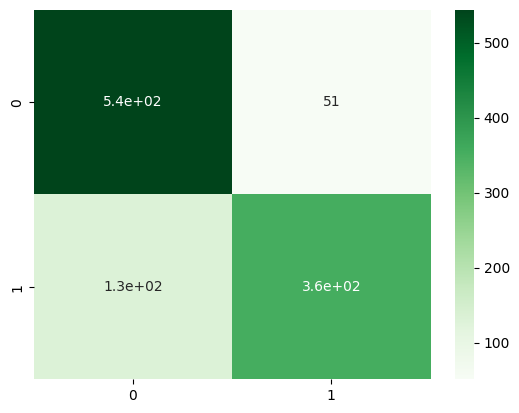

In [54]:
# classify using random forest classifier
classifier = RandomForestClassifier(random_state=0)
classifier.fit(X_train, Y_train)

X_train_prediction=classifier.predict(X_train)
rf_training_accuracy= accuracy_score(X_train_prediction,Y_train)

X_test_prediction=classifier.predict(X_test)
rf_test_accuracy= accuracy_score(X_test_prediction,Y_test)

print("Training accuracy:", rf_training_accuracy*100)
print("Testing accuracy:", rf_test_accuracy*100)

print(classification_report(Y_test,X_test_prediction))

cm = confusion_matrix(Y_test, X_test_prediction)
print(cm)

sns.heatmap(cm, annot=True, cmap='Greens')
plt.show()